In [5]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Layer, Add
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras import optimizers
from skimage.transform import rotate
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
import cv2
import plotly.graph_objects as go
import os
import mlflow
import mlflow.tensorflow
from plotly.subplots import make_subplots
%matplotlib inline

In [42]:
df  = pd.read_csv('../../cleaneddataset2.csv')

In [43]:
mlflow.tensorflow.autolog()

In [44]:
df

SiteName  Depth(m) Diver  ImageNumber  ImageAnalyzedNumber  \
0     Nowlans Shoal         6    AB            8                  1.0   
1     Nowlans Shoal         6    AB           11                  2.0   
2     Nowlans Shoal         6    AB           14                  3.0   
3     Nowlans Shoal         6    AB           17                  4.0   
4     Nowlans Shoal         6    AB           20                  5.0   
...             ...       ...   ...          ...                  ...   
1064        Goose I         9    KA           27                  NaN   
1065        Goose I         9    KA           35                  NaN   
1066        Goose I         9    KA           41                  NaN   
1067        Goose I         9    KA           47                  NaN   
1068        Goose I         9    KA           53                  NaN   

      PhotoAnalyzed(0,1)  ReasonOmitted  ImageWidth(cm)  ImageLength(cm)  \
0                      1            NaN          178.84           100.53   
1                      1            NaN          179.00           100.62   
2                      1            NaN          172.65            97.05   
3                      1            NaN          166.20            93.42   
4                      1            NaN          184.24           103.57   
...                  ...            ...             ...              ...   
1064                   1            NaN          196.23           110.31   
1065                   1            NaN          180.55           101.49   
1066                   1            NaN          193.99           109.05   
1067                   1            NaN          196.61           110.52   
1068                   1            NaN          189.38           106.45   

      AreaPerPoint(cm^2)  ... MixedChondrusTurfCorallina  \
0                  200.0  ...                        NaN   
1                  200.0  ...                       15.0   
2                  175.0  ...                        NaN   
3                  175.0  ...                        NaN   
4                  200.0  ...                        0.0   
...                  ...  ...                        ...   
1064               225.0  ...                        3.0   
1065               195.0  ...                        NaN   
1066               220.0  ...                        1.0   
1067               220.0  ...                        NaN   
1068               220.0  ...                        0.0   

      JuvenileSaccharinaLatissima  MixedChondrusCoralina  MixedTurfCorallina  \
0                             NaN                    NaN                 NaN   
1                             NaN                    NaN                 NaN   
2                             NaN                    NaN                 NaN   
3                             NaN                    NaN                 NaN   
4                             0.0                    0.0                 2.0   
...                           ...                    ...                 ...   
1064                          NaN                    NaN                 NaN   
1065                          NaN                    NaN                 NaN   
1066                          NaN                    NaN                 NaN   
1067                          NaN                    NaN                 NaN   
1068                          3.0                    NaN                 NaN   

      TotalPts  Kelp  algae1  algae2  rock  unknown  
0           91    26      24      41     0        0  
1           91    17      44      30     0        0  
2           91    10      35      46     0        0  
3           91    22      37      32     0        0  
4           91    13      26      52     0        0  
...        ...   ...     ...     ...   ...      ...  
1064        91    85       3       0     0        3  
1065        91    89       2       0     0        0  
1066        91    89       1       0     0        1  

In [39]:
df[['Kelp', 'algae1', 'algae2', 'rock', 'unknown']] = df[['Kelp', 'algae1', 'algae2', 'rock', 'unknown']].fillna(0)
df[['Kelp', 'algae1', 'algae2', 'rock', 'unknown']] = df[['Kelp', 'algae1', 'algae2', 'rock', 'unknown']].div(df[['Kelp', 'algae1', 'algae2', 'rock', 'unknown']].sum(axis=1), axis=0)
df

SiteName  Depth(m) Diver  ImageNumber  ImageAnalyzedNumber  \
0     Nowlans Shoal         6    AB            8                  1.0   
1     Nowlans Shoal         6    AB           11                  2.0   
2     Nowlans Shoal         6    AB           14                  3.0   
3     Nowlans Shoal         6    AB           17                  4.0   
4     Nowlans Shoal         6    AB           20                  5.0   
...             ...       ...   ...          ...                  ...   
1064        Goose I         9    KA           27                  NaN   
1065        Goose I         9    KA           35                  NaN   
1066        Goose I         9    KA           41                  NaN   
1067        Goose I         9    KA           47                  NaN   
1068        Goose I         9    KA           53                  NaN   

      PhotoAnalyzed(0,1)  ReasonOmitted  ImageWidth(cm)  ImageLength(cm)  \
0                      1            NaN          178.84           100.53   
1                      1            NaN          179.00           100.62   
2                      1            NaN          172.65            97.05   
3                      1            NaN          166.20            93.42   
4                      1            NaN          184.24           103.57   
...                  ...            ...             ...              ...   
1064                   1            NaN          196.23           110.31   
1065                   1            NaN          180.55           101.49   
1066                   1            NaN          193.99           109.05   
1067                   1            NaN          196.61           110.52   
1068                   1            NaN          189.38           106.45   

      AreaPerPoint(cm^2)  ... MixedChondrusTurfCorallina  \
0                  200.0  ...                        NaN   
1                  200.0  ...                       15.0   
2                  175.0  ...                        NaN   
3                  175.0  ...                        NaN   
4                  200.0  ...                        0.0   
...                  ...  ...                        ...   
1064               225.0  ...                        3.0   
1065               195.0  ...                        NaN   
1066               220.0  ...                        1.0   
1067               220.0  ...                        NaN   
1068               220.0  ...                        0.0   

      JuvenileSaccharinaLatissima  MixedChondrusCoralina  MixedTurfCorallina  \
0                             NaN                    NaN                 NaN   
1                             NaN                    NaN                 NaN   
2                             NaN                    NaN                 NaN   
3                             NaN                    NaN                 NaN   
4                             0.0                    0.0                 2.0   
...                           ...                    ...                 ...   
1064                          NaN                    NaN                 NaN   
1065                          NaN                    NaN                 NaN   
1066                          NaN                    NaN                 NaN   
1067                          NaN                    NaN                 NaN   
1068                          3.0                    NaN                 NaN   

      TotalPts      Kelp    algae1    algae2  rock   unknown  
0           91  0.285714  0.263736  0.450549   0.0  0.000000  
1           91  0.186813  0.483516  0.329670   0.0  0.000000  
2           91  0.109890  0.384615  0.505495   0.0  0.000000  
3           91  0.241758  0.406593  0.351648   0.0  0.000000  
4           91  0.142857  0.285714  0.571429   0.0  0.000000  
...        ...       ...       ...       ...   ...       ...  
1064        91  0.934066  0.032967  0.000000   0.0  0.032967  
1065        91  0.978022  0.021978 

In [ ]:
0.622449,0.030612,0.285714,0.051020,0.010204

In [10]:
islands = ['Barren I', 'Bird I', 'Fish I', 'Gold I', 'Harbour I', 'Long I', 'Nowlans Shoal', 'Speck I', 'The Moll']

In [11]:
# balance_y = pd.DataFrame(columns=['Kelp', 'algae1', 'algae2', 'rock', 'unknown'])
# colorspace_y = pd.DataFrame(columns=['Kelp', 'algae1', 'algae2', 'rock', 'unknown'])
# len(balance_y)

In [12]:
# balance_y

In [13]:
train_image = []
train_labels = []
# test_image = []
# balance_x = []
# colorspace_x = []
test_image = []
test_labels = []
scale_percent = 10
for i in tqdm(df.itertuples()):
    label = [i.Kelp, i.algae1, i.algae2, i.rock, i.unknown]
    island = i.SiteName.replace(" ", "")
    m = str(i[2]) + 'm'
    diver = m + '_' + i.Diver
    im_num = str(i.ImageNumber).zfill(3)
    im_name = island + str(i[2]) + i.Diver[0] + '_' + im_num


    path = "../../videos/" + island + '/' + diver + '/'
    directory = os.listdir(path)


    if(island=='BarrenI' and diver=='6m_KA'):
        img3 = cv2.imread(path + str(i.ImageNumber) + '.jpg')
        img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
        width3 = int(img3.shape[1] * scale_percent / 100)
        height3 = int(img3.shape[0] * scale_percent / 100)
        dim3 = (width3, height3)
        resized3 = cv2.resize(img3, dim3)
        train_image.append(resized3)
        train_labels.append(label)

    elif(island=='TheMoll'):
        images = []
        for j in sorted(directory):
            num = j.split('.jpg')[0]
            images.append(num)

        dict1 = {}
        for k,l in enumerate(images):
            if('-' in l):
                first = int(l.split('-')[0])
                if(first==0):
                    dict1[l] = [m for m in range(1,11)]
                else:
                    before = first - 10
                    after = first + 10
                    list1 = [n for n in range(before, first)]
                    list2 = [o for o in range(first, after)]
                    list3 = list1 + list2
                    dict1[l] = list3

        for p in dict1:
            key = int(p.split('-')[1])
            if(key==i.ImageNumber):
                img1 = cv2.imread(path + p + '.jpg')
                img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
                width = int(img1.shape[1] * scale_percent / 100)
                height = int(img1.shape[0] * scale_percent / 100)
                dim = (width, height)
                resized1 = cv2.resize(img1, dim)
                test_image.append(resized1)
                test_labels.append(label)
                for q in dict1[p]:
                    img2 = cv2.imread(path + str(q) + '.jpg')
                    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
                    width2 = int(img2.shape[1] * scale_percent / 100)
                    height2 = int(img2.shape[0] * scale_percent / 100)
                    dim2 = (width2, height2)
                    resized2 = cv2.resize(img2, dim2)
                    test_image.append(resized2)
                    test_labels.append(label)

    else:
        images = []
        for j in sorted(directory):
            num = j.split('.jpg')[0]
            images.append(num)

        dict1 = {}
        for k,l in enumerate(images):
            if('-' in l):
                first = int(l.split('-')[0])
                if(first==0):
                    dict1[l] = [m for m in range(1,11)]
                else:
                    before = first - 10
                    after = first + 10
                    list1 = [n for n in range(before, first)]
                    list2 = [o for o in range(first, after)]
                    list3 = list1 + list2
                    dict1[l] = list3

        for p in dict1:
            key = int(p.split('-')[1])
            if(key==i.ImageNumber):
                img1 = cv2.imread(path + p + '.jpg')
                img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
                width = int(img1.shape[1] * scale_percent / 100)
                height = int(img1.shape[0] * scale_percent / 100)
                dim = (width, height)
                resized1 = cv2.resize(img1, dim)
                train_image.append(resized1)
                train_labels.append(label)
                for q in dict1[p]:
                    img2 = cv2.imread(path + str(q) + '.jpg')
                    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
                    width2 = int(img2.shape[1] * scale_percent / 100)
                    height2 = int(img2.shape[0] * scale_percent / 100)
                    dim2 = (width2, height2)
                    resized2 = cv2.resize(img2, dim2)
                    train_image.append(resized2)
                    train_labels.append(label)



1069it [25:02,  1.41s/it]


In [14]:
X_train = np.array(train_image, dtype='float32')

In [15]:
X_test = np.array(test_image, dtype='float32')

In [16]:
y_train = np.array(train_labels, dtype='float32')

In [17]:
y_test = np.array(test_labels, dtype='float32')

In [18]:
X_test.shape

(1365, 152, 270, 3)

In [19]:
X_train = X_train/255.0
X_test = X_test/255.0

In [22]:
fig = make_subplots(rows=5, cols=2, subplot_titles=['Kelp Train', 'Kelp Test', 'Algae1 Train', 'Algae1 Test','Algae2 Train', 'Algae2 Test', 'Rock Train', 'Rock Test', 'Unknown Train', 'Unknown Test'])

fig.add_trace(go.Histogram(x=y_train[:,0], name='Kelp Train'), row=1, col=1)
fig.add_trace(go.Histogram(x=y_test[:,0], name='Kelp Test'), row=1, col=2)
fig.add_trace(go.Histogram(x=y_train[:,1], name='Algae1 Train'), row=2, col=1)
fig.add_trace(go.Histogram(x=y_test[:,1], name='Algae1 Test'), row=2, col=2)
fig.add_trace(go.Histogram(x=y_train[:,2], name='Algae2 Train'), row=3, col=1)
fig.add_trace(go.Histogram(x=y_test[:,2], name='ALgae2 Test'), row=3, col=2)
fig.add_trace(go.Histogram(x=y_train[:,3], name='Rock Train'), row=4, col=1)
fig.add_trace(go.Histogram(x=y_test[:,3], name='Rock Test'), row=4, col=2)
fig.add_trace(go.Histogram(x=y_train[:,4], name='Unknown Train'), row=5, col=1)
fig.add_trace(go.Histogram(x=y_test[:,4], name='Unknown Test'), row=5, col=2)

fig.update_layout(title_text="Percentage Distribution", height=1500, xaxis_title="Percent Distribution", yaxis_title="Count")
go.Figure.write_html(fig,"Distribution.html")
fig.show()

In [27]:
def generate_class_weights(class_series):
    mlb = None
    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))
class_weights = generate_class_weights(y_train)

In [28]:
class_weights

{0: 0.20663270504330106,
 1: 0.22387680759465725,
 2: 0.42287322768974145,
 3: 1.6096031746031747,
 4: 0.6129968263563549}

In [29]:
X_train.shape

(20281, 152, 270, 3)

In [26]:
class ResnetBlock(Model):
    def __init__(self, channels: int, down_sample=False):

        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)

        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [31]:
model = ResNet18(5)
model.build(input_shape = (None, 152, 270, 3))

model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple          

In [32]:
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [33]:
model.compile(optimizer = sgd,loss=tf.keras.losses.KLDivergence(), metrics=['accuracy',tf.keras.metrics.AUC()])

In [34]:
early_stopping = EarlyStopping(patience=15, monitor='val_loss', verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint("themoll.ckpt", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)


In [35]:
len(X_test)

1365

In [36]:
import math
batch_size=32
trainingsize = len(X_train)
validate_size = len(X_test)
def calculate_spe(y):
  return int(math.ceil((1. * y) / batch_size))
steps_per_epoch = calculate_spe(trainingsize)
validation_steps = calculate_spe(validate_size)

In [37]:
history = model.fit(X_train, y_train,  use_multiprocessing=True,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    class_weight=class_weights, callbacks=[early_stopping, checkpoint, reduce_lr])

2022/07/01 00:51:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '62b8308a32754411b4f0cfd399201672', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50
634/634 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.7849 - auc: 0.8597
Epoch 1: val_loss improved from inf to 0.38048, saving model to themoll.ckpt


INFO:tensorflow:Assets written to: themoll.ckpt\assets


INFO:tensorflow:Assets written to: themoll.ckpt\assets


634/634 [==============================] - 1024s 2s/step - loss: 0.0676 - accuracy: 0.7849 - auc: 0.8597 - val_loss: 0.3805 - val_accuracy: 0.7223 - val_auc: 0.7943 - lr: 0.0010
Epoch 2/50
634/634 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.8687 - auc: 0.8697
Epoch 2: val_loss improved from 0.38048 to 0.33648, saving model to themoll.ckpt


INFO:tensorflow:Assets written to: themoll.ckpt\assets


INFO:tensorflow:Assets written to: themoll.ckpt\assets


634/634 [==============================] - 1083s 2s/step - loss: 0.0434 - accuracy: 0.8687 - auc: 0.8697 - val_loss: 0.3365 - val_accuracy: 0.7641 - val_auc: 0.8173 - lr: 0.0010
Epoch 3/50
634/634 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.8841 - auc: 0.8751
Epoch 3: val_loss did not improve from 0.33648
634/634 [==============================] - 1100s 2s/step - loss: 0.0367 - accuracy: 0.8841 - auc: 0.8751 - val_loss: 0.3458 - val_accuracy: 0.7714 - val_auc: 0.8234 - lr: 0.0010
Epoch 4/50
634/634 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.8977 - auc: 0.8798
Epoch 4: val_loss improved from 0.33648 to 0.30276, saving model to themoll.ckpt


INFO:tensorflow:Assets written to: themoll.ckpt\assets


INFO:tensorflow:Assets written to: themoll.ckpt\assets


634/634 [==============================] - 1030s 2s/step - loss: 0.0328 - accuracy: 0.8977 - auc: 0.8798 - val_loss: 0.3028 - val_accuracy: 0.7700 - val_auc: 0.8363 - lr: 0.0010
Epoch 5/50
634/634 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9031 - auc: 0.8829
Epoch 5: val_loss improved from 0.30276 to 0.28490, saving model to themoll.ckpt


INFO:tensorflow:Assets written to: themoll.ckpt\assets


INFO:tensorflow:Assets written to: themoll.ckpt\assets


634/634 [==============================] - 1538s 2s/step - loss: 0.0299 - accuracy: 0.9031 - auc: 0.8829 - val_loss: 0.2849 - val_accuracy: 0.7963 - val_auc: 0.8374 - lr: 0.0010
Epoch 6/50
634/634 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9092 - auc: 0.8854
Epoch 6: val_loss did not improve from 0.28490
634/634 [==============================] - 1580s 2s/step - loss: 0.0275 - accuracy: 0.9092 - auc: 0.8854 - val_loss: 0.3628 - val_accuracy: 0.7136 - val_auc: 0.8282 - lr: 0.0010
Epoch 7/50
634/634 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9121 - auc: 0.8879
Epoch 7: val_loss did not improve from 0.28490
634/634 [==============================] - 1540s 2s/step - loss: 0.0260 - accuracy: 0.9121 - auc: 0.8879 - val_loss: 0.2854 - val_accuracy: 0.7773 - val_auc: 0.8373 - lr: 0.0010
Epoch 8/50
634/634 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9155 - auc: 0.8907
Epoch 8: val_loss did not improve from 0.2

INFO:tensorflow:Assets written to: themoll.ckpt\assets


INFO:tensorflow:Assets written to: themoll.ckpt\assets


634/634 [==============================] - 1449s 2s/step - loss: 0.0180 - accuracy: 0.9321 - auc: 0.8997 - val_loss: 0.2742 - val_accuracy: 0.8081 - val_auc: 0.8238 - lr: 0.0010
Epoch 15/50
634/634 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9319 - auc: 0.9000
Epoch 15: val_loss did not improve from 0.27416
634/634 [==============================] - 1794s 3s/step - loss: 0.0174 - accuracy: 0.9319 - auc: 0.9000 - val_loss: 0.3242 - val_accuracy: 0.7897 - val_auc: 0.8211 - lr: 0.0010
Epoch 16/50
634/634 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9375 - auc: 0.9014
Epoch 16: val_loss did not improve from 0.27416
634/634 [==============================] - 1774s 3s/step - loss: 0.0165 - accuracy: 0.9375 - auc: 0.9014 - val_loss: 0.2763 - val_accuracy: 0.8220 - val_auc: 0.8237 - lr: 0.0010
Epoch 17/50
634/634 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9376 - auc: 0.9022
Epoch 17: val_loss did not improve fr

INFO:tensorflow:Assets written to: C:\Users\gawai\AppData\Local\Temp\tmpze6i3ft5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\gawai\AppData\Local\Temp\tmpze6i3ft5\model\data\model\assets
2022/07/01 14:13:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\gawai\anaconda3\envs\bunny\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


In [38]:
import plotly.graph_objects as go
import numpy as np

# fig, ax = plt.subplots()

# ax.plot(list(range(len(train_loss))), train_loss)
# ax.plot(list(range(len(test_loss))), test_loss)
# ax.set_yscale('log')
# plt.savefig('example.png')
# # plt.yscale('log')
# plt.show()
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(history.history['loss']))), y=history.history['loss'], name='train loss', mode='lines'))
fig.add_trace(go.Scatter(x=list(range(len(history.history['val_loss']))), y=history.history['val_loss'], name='test loss', mode='lines'))
fig.update_layout(xaxis_title='Epochs', yaxis_title='loss')
# fig.update_yaxes(type="log")
# fig.update_yaxes(range = [0,1])
# # fig.write_image("fig1.png")
fig.show()

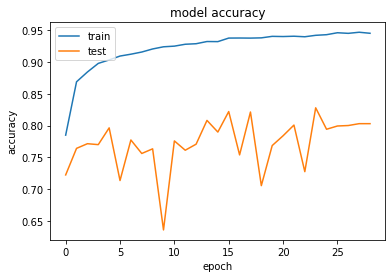

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('acc.png')
plt.show()

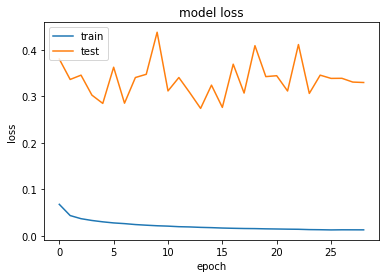

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
model = ResNet18(5)
model.build(input_shape = (None, 152, 270, 3))
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer = sgd,loss=tf.keras.losses.KLDivergence(), metrics=['accuracy',tf.keras.metrics.AUC()])
model.load_weights('themoll.ckpt')

loss,acc,auc = model.evaluate(X_test,  y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
43/43 - 14s - loss: 0.2745 - accuracy: 0.8088 - auc: 0.8239 - 14s/epoch - 317ms/step
Restored model, accuracy: 80.88%


In [28]:
proba = model.predict(X_test)

43/43 [==============================] - 12s 266ms/step


In [29]:
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(y_test, proba)
print(mape)

0.08918809


In [30]:
kelp = []
algae1 = []
algae2 =[]
rock = []
unknown = []
avrg = []
for i, j in zip(proba, y_test):
    k_mae = np.round(abs(i[0]-j[0]), 3)
    a1_mae = np.round(abs(i[1]-j[1]), 3)
    a2_mae = np.round(abs(i[2]-j[2]), 3)
    r_mae = np.round(abs(i[3]-j[3]), 3)
    u_mae = np.round(abs(i[4]-j[4]), 3)
    avg = (k_mae + a1_mae + a2_mae + r_mae + u_mae)/5

    kelp.append(k_mae)
    algae1.append(a1_mae)
    algae2.append(a2_mae)
    rock.append(r_mae)
    unknown.append(u_mae)
    avrg.append(avg)

In [31]:
k = sum(kelp)/len(kelp)
a1 = sum(algae1)/len(algae1)
a2 = sum(algae2)/len(algae2)
r = sum(rock)/len(rock)
u = sum(unknown)/len(unknown)
print(k, a1, a2, r, u)

0.15097728948835487 0.16988131872825188 0.09355824178309886 0.015318681465908748 0.01619706969254483


In [32]:
fig = make_subplots(rows=3, cols=2, subplot_titles=['Kelp Error', 'Algae1 Error', 'Algae2 Error', 'Rock Error', 'Unknown Error'])

fig.add_trace(go.Histogram(x=kelp, name='Kelp'), row=1, col=1)
fig.add_trace(go.Histogram(x=algae1, name='Algae1'), row=1, col=2)
fig.add_trace(go.Histogram(x=algae2, name='Algae2'), row=2, col=1)
fig.add_trace(go.Histogram(x=rock, name='Rock'), row=2, col=2)
fig.add_trace(go.Histogram(x=unknown, name='Unknown'), row=3, col=1)

fig.update_layout(title_text="Absolute Error", height=1000, xaxis_title="Number of samples", yaxis_title="Absolute Error")
go.Figure.write_html(fig,"error.html")
fig.show()

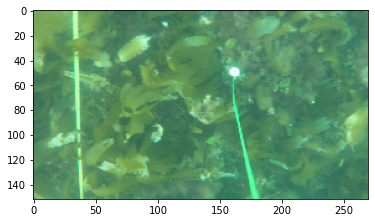

In [45]:
imgtest = image.load_img('../../EasternShoreIslandsKelpSurvey2018/TheMoll/6m_AB/TheMoll6A_039.jpg', target_size=(152, 270, 3))
imgtest_ = image.img_to_array(imgtest)
imgtest_ = imgtest_/255
plt.imshow(imgtest_)

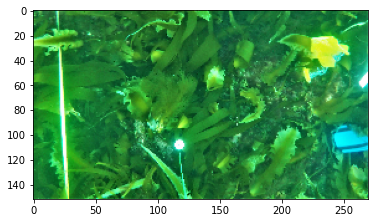

In [46]:
imgtest1 = image.load_img('../../EasternShoreIslandsKelpSurvey2018/TheMoll/6m_AB/TheMoll6A_006.jpg', target_size=(152, 270, 3))
imgtest1_ = image.img_to_array(imgtest1)
imgtest1_ = imgtest1_/255
plt.imshow(imgtest1_)

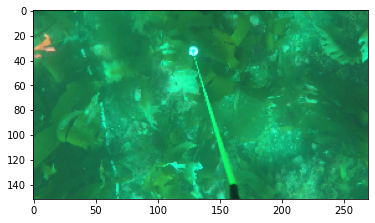

In [49]:
imgtest2 = image.load_img('../../EasternShoreIslandsKelpSurvey2018/TheMoll/9m_AB/TheMoll9A_067.jpg', target_size=(152, 270, 3))
imgtest2_ = image.img_to_array(imgtest2)
imgtest2_ = imgtest2_/255
plt.imshow(imgtest2_)

In [53]:
classes = np.array(['Kelp', 'Algae1', 'Algae2', 'Rock', 'Unknown'])
proba = model.predict(imgtest2_.reshape(1, 152, 270, 3))
# pred = proba.round()
# print(pred)
top_3 = np.argsort(proba[0])[:-6:-1]
for i in range(5):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
# plt.imshow(imgtest2)

1/1 [==============================] - 0s 41ms/step
Kelp (0.597)
Algae1 (0.343)
Algae2 (0.0332)
Rock (0.0189)
Unknown (0.00775)


In [40]:
0.650000,0.316667,0.025000,0.000000,0.008333

(0.65, 0.316667, 0.025, 0.0, 0.008333)

In [ ]:
0.644231,0.182692,0.000000,0.000000,0.173077

In [ ]:
0.622449,0.030612,0.285714,0.051020,0.010204